In [ ]:
# Imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
% matplotlib inline 

# 加载数据
path = r"./房地产行业财务风险数据.xlsx"
# skipfooter=3

Matrix_pre = np.zeros(shape=(4,1))

#print (Matrix_pre)

for i in range(0,16):
    
    print('**************************************************************************\n')
    print('**************************当前是第'+str(i)+'列数据,共16列**************************\n')
    print('**************************************************************************\n')

    dataset = pd.read_excel(path, sheet_name = 'Sheet2',header=None, usecols= [i],  nrows = 20)
    dataset = np.array(dataset)
    print(dataset)
    plt.plot(dataset)
    plt.show()
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataSet = scaler.fit_transform(dataset)

    # split into train and test sets; 80% 是训练数据，其余是测试数据
    train_size = int(len(dataSet) * 0.8)
    test_size = len(dataSet) - train_size
    train, test = dataSet[0:train_size], dataSet[train_size:len(dataSet)]

    # 数据格式转化(t,t+1)
    def convert_data(data, time_step=1):
        data_X,data_Y = [],[]  
        for i in range(len(data) - time_step - 1):
            x = data[i: (i + time_step)]  
            y = data[i+1:i + time_step+1]      
            data_X.append(x.tolist())
            data_Y.append(y.tolist()) 
        return data_X, data_Y
    

    time_step = 5      # 时间步
    train_x, train_y = convert_data(train, time_step)
    test_x, test_y = convert_data(test, time_step)

    #———————————————————形成训练集—————————————————————
    #设置常量
    hidden_unit = 10       # hidden layer units 记忆和储存过去状态的节点个数
    batch_size = 4    # 每一批次训练多少个样例
    input_size = 1      # 输入层维度
    output_size = 1     # 输出层维度
    lr = 0.0001       # 学习率

    import tensorflow as tf

    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    print("tensorflow运行版本：" + tf.__version__)
        
    # LSTM 的 X 需要有这样的结构： [samples, time steps, features]，所以做一下变换
    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, [None,time_step,input_size], name="inputs")    #每批次输入网络的tensor
        Y = tf.placeholder(tf.float32, [None,time_step,output_size])   #每批次tensor对应的标签
    # 输入层、输出层权重、偏置
    with tf.name_scope('layer'):
        with tf.name_scope('weights'):
            weights={
                 'in':tf.Variable(tf.random_normal([input_size,hidden_unit])),
                 'out':tf.Variable(tf.random_normal([hidden_unit,1]))
                 }
        with tf.name_scope('biases'):
            biases={
                'in':tf.Variable(tf.constant(0.1,shape=[hidden_unit,])),
                'out':tf.Variable(tf.constant(0.1,shape=[1,]))
                 }




    #  网络定义
    def lstm(batch):  #参数：输入网络批次数目

        w_in = weights['in']
        b_in = biases['in']
        input = tf.reshape(X,[-1,input_size],dtype=tf.float32))  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
        with tf.name_scope('cells'):
            lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_unit) #10个节点
            input_lstm = tf.matmul(input, w_in) + b_in
            input_lstm = tf.reshape(input_lstm, [-1, time_step, hidden_unit])  #将tensor转成3维，作为lstm cell的输入      
            print(input_lstm)
            init_state = lstm_cell.zero_state(batch,dtype = tf.float32)
            # output_rnn是记录lstm每个隐状态输出节点的结果，final_states是最后一个cell的结果，数据格式为tuple
            output_rnn, final_states = tf.nn.dynamic_rnn(
                lstm_cell, 
                input_lstm, 
                initial_state = init_state, 
                dtype = tf.float32
            ) 
            output = tf.reshape(output_rnn, [-1, hidden_unit]) #  作为输出层的输入
            # 将w b输出
            w_out = weights['out']
            b_out = biases['out']
            # 预测数据
            multi = tf.matmul(output, w_out)
            pred = tf.add(multi, b_out, name='pred')           
            return pred, final_states
    
    
    # 训练模型函数封装
    train_loss = []
    def train_lstm():   
        global batch_size
        iteration = 1
        epochs = 1000
        pred, _ = lstm(batch_size)
        # 损失函数
        loss = tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
        train_op = tf.train.AdamOptimizer(lr).minimize(loss)
        saver = tf.train.Saver(tf.global_variables())
        
        with tf.Session() as sess:
            keep_prob = tf.placeholder(tf.float32, name="keep_prob")
            sess.run(tf.global_variables_initializer())
            for e in range(epochs):
                step=0
                start = 0
                end = start + batch_size
                while(end < len(train_x)):
                    x = train_x[start:end]
                    y = train_y[start:end]
                    feed = {X: x, Y:y, keep_prob : 0.3}
                    _,loss_ = sess.run([train_op, loss], feed_dict = feed)
                    start += batch_size
                    end = start + batch_size
                    # 每10步保存一次参数
                    if step% 10 == 0:                    
                        print("Epoch: {}/{}".format(e, epochs),
                        "Iteration: {:d}".format(iteration),
                        "Train loss: {:6f}".format(loss_))            
                    train_loss.append(loss_)
                    iteration += 1  
                    step += 1            
            # 保存二进制模型
            # 显示图中的节点
            #print([n.name for n in sess.graph.as_graph_def().node])
            output_graph_def = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=["rnn/cells/pred"])
            with tf.gfile.FastGFile('./models/basicPred_'+str(i)+ '.pb', mode='wb') as f:
                f.write(output_graph_def.SerializeToString())
            saver.save(sess, "./predicts"+str(i)+".ckpt")
            #绘训练过程指标图
            t = np.arange(iteration - 1)
            plt.figure(figsize = (9,6))
            plt.plot(t, np.array(train_loss),  'r-')
            plt.xlabel("iteration")
            plt.ylabel("Loss")
            plt.legend(['train'], loc='upper right')
            plt.show()        

    # 模型训练
    with tf.variable_scope('rnn', reuse=tf.AUTO_REUSE):
        train_lstm()
        
        
        
        
        
     # 预测
    from sklearn.metrics import mean_squared_error
    import math

    def prediction():

            pred, _ = lstm(1)  # 预测时只输入[1,time_step,inputSize]的测试数据
            saver = tf.train.Saver(tf.global_variables())
            #预测季度
            pre_quarter = 4
            with tf.Session() as sess:
                # 参数恢复
                module_file = tf.train.latest_checkpoint("./")
                saver.restore(sess, module_file)
                # 取训练集最后一行为测试样本. shape=[1,time_step,inputSize]
                prev_seq = train_x[-1]
                predict = []
                # 得到之后10个季度的预测结果
                for i in range(pre_quarter):
                    next_seq = sess.run(pred,feed_dict={X:[prev_seq]})
                    predict.append(next_seq[-1])   
                    #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
                    #np.vstack()表示垂直（按照行顺序）的把数组给堆叠起来。
                    prev_seq = np.vstack((prev_seq[1:],next_seq[-1]))

                #得到实际预测值
                predictY = scaler.inverse_transform(predict)

                testY = scaler.inverse_transform(test)
                print("预测值：", predictY)
                print("真实值：",testY )
                global Matrix_pre
                Matrix_pre = (np.hstack((Matrix_pre,predictY)))


                #以折线图表示结果
                plt.figure()
                plt.title("lead index")
                plt.plot(list(range(len(testY))), testY, 'cx--', list(range(len(predict))), predictY, 'b--')
                plt.xlabel("date-num")
                plt.ylabel("index")
                plt.legend(['train', 'pred'], loc='upper right')
                plt.plot()
                plt.show()
    # 共享变量 TF1.9
    with tf.variable_scope('rnn', reuse = tf.AUTO_REUSE):
        prediction() 

#存进excel文件
Matrix_input = pd.DataFrame(Matrix_pre)
writer = pd.ExcelWriter('./房地产行业财务风险预测数据.xlsx')
Matrix_input.to_excel(writer, float_format='%.2f', header = False, index = False,) # float_format 控制精度
writer.save()

print('**************************************************************************\n')
print('*********************************迭代结束*********************************\n')
print('**************************************************************************')

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat
from matplotlib import style
import pandas as pd

'''读入原始数据并转为list'''
filePath = r"./房地产行业财务风险数据.xlsx"
data = pd.read_excel(filePath, header=None)
data = data.iloc[:,0].tolist()

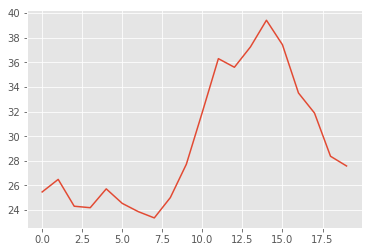

In [2]:
'''自定义数据尺度缩放函数'''
def data_processing(raw_data,scale=True):
    if scale == True:
        return (raw_data-np.mean(raw_data))/np.std(raw_data)#标准化
    else:
        return (raw_data-np.min(raw_data))/(np.max(raw_data)-np.min(raw_data))#极差规格化

'''观察数据'''

'''设置绘图风格'''
style.use('ggplot')

plt.plot(data)

In [5]:
'''设置隐层神经元个数'''
HIDDEN_SIZE = 10
'''设置隐层层数'''
NUM_LAYERS = 1
'''设置一个时间步中折叠的递归步数'''
TIMESTEPS = 5
'''设置训练轮数'''
TRAINING_STEPS = 1000
'''设置训练批尺寸'''
BATCH_SIZE = 5

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbadfb6eba8>, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_is_chief': True, '_session_config': None, '_num_worker_replicas': 0, '_master': '', '_save_checkpoints_steps': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_model_dir': 'Models/model_2', '_tf_random_seed': None, '_log_step_count_steps': 100, '_task_type': None, '_device_fn': None, '_evaluation_master': '', '_train_distribute': None, '_environment': 'local', '_task_id': 0, '_save_checkpoints_secs': 600}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Models/model_2/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2

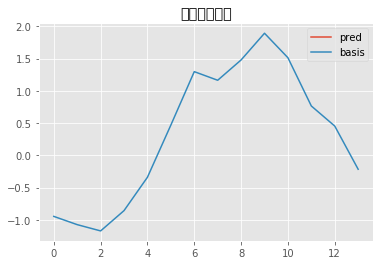

In [9]:
'''样本数据生成函数'''
def generate_data(seq):
    X = []#初始化输入序列X
    Y= []#初始化输出序列Y
    '''生成连贯的时间序列类型样本集，每一个X内的一行对应指定步长的输入序列，Y内的每一行对应比X滞后一期的目标数值'''
    for i in range(len(seq) - TIMESTEPS - 1):
        X.append([seq[i:i + TIMESTEPS]])#从输入序列第一期出发，等步长连续不间断采样
        Y.append([seq[i + TIMESTEPS]])#对应每个X序列的滞后一期序列值
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)


'''定义LSTM cell组件，该组件将在训练过程中被不断更新参数'''
def LstmCell():
    lstm_cell = rnn.BasicLSTMCell(HIDDEN_SIZE, state_is_tuple=True)#
    return lstm_cell

'''定义LSTM模型'''
def lstm_model(X, y):
    '''以前面定义的LSTM cell为基础定义多层堆叠的LSTM，我们这里只有1层'''
    cell = rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])

    '''将已经堆叠起的LSTM单元转化成动态的可在训练过程中更新的LSTM单元'''
    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

    '''根据预定义的每层神经元个数来生成隐层每个单元'''
    output = tf.reshape(output, [-1, HIDDEN_SIZE])

    '''通过无激活函数的全连接层计算线性回归，并将数据压缩成一维数组结构'''
    predictions = tf.contrib.layers.fully_connected(output, 1, None)

    '''统一预测值与真实值的形状'''
    labels = tf.reshape(y, [-1])
    predictions = tf.reshape(predictions, [-1])

    '''定义损失函数，这里为正常的均方误差'''
    loss = tf.losses.mean_squared_error(predictions, labels)

    '''定义优化器各参数'''
    train_op = tf.contrib.layers.optimize_loss(loss,
                                               tf.contrib.framework.get_global_step(),
                                               optimizer='Adagrad',
                                               learning_rate=0.6)
    '''返回预测值、损失函数及优化器'''
    return predictions, loss, train_op

'''载入tf中仿sklearn训练方式的模块'''
learn = tf.contrib.learn

'''初始化我们的LSTM模型，并保存到工作目录下以方便进行增量学习'''
regressor = SKCompat(learn.Estimator(model_fn=lstm_model, model_dir='Models/model_2'))

'''对原数据进行尺度缩放'''
data = data_processing(data)

'''切分训练集与测试集'''

# train_size = int(len(data) * 1)
# test_size = len(data) - train_size
# train, test = data[0:train_size], data[train_size:len(data)]


'''将所有样本来作为训练样本'''
train_X, train_y = generate_data(data)

'''将所有样本作为测试样本'''
test_X, test_y = generate_data(data)

'''以仿sklearn的形式训练模型，这里指定了训练批尺寸和训练轮数'''
regressor.fit(train_X, train_y, batch_size=BATCH_SIZE, steps=TRAINING_STEPS)






'''利用已训练好的LSTM模型，来生成对应测试集的所有预测值'''


# prev_seq = test_X[-1]
# predicted = []
# # 得到之后10个季度的预测结果
# for i in range(4):
next_seq= np.array([pred for pred in regressor.predict(test_X)])
    #next_seq = sess.run(pred,feed_dict={X:[prev_seq]})
#     predicted.append(next_seq[-1])   
#     #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
#     #np.vstack()表示垂直（按照行顺序）的把数组给堆叠起来。
#     prev_seq = np.vstack((prev_seq[1:],next_seq[-1]))


# print(predicted)







'''绘制反标准化之前的真实值与预测值对比图'''
plt.figure()
plt.plot(predicted, label='pred')
plt.plot(test_y, label='basis')
plt.title('反标准化之前')
plt.legend()
plt.show()

In [ ]:
'''自定义反标准化函数'''
def scale_inv(raw_data,scale=True):
    '''读入原始数据并转为list'''
    filePath = r"./房地产行业财务风险数据.xlsx"

    data = pd.read_excel(filePath)

    data = data.iloc[:, 0].tolist()

    if scale == True:
        return raw_data*np.std(data)+np.mean(data)
    else:
        return raw_data*(np.max(data)-np.min(data))+np.min(data)

pred = scale_inv(predicted)
basis = scale_inv(test_y)
print(pred)
print(basis)
'''绘制反标准化之前的真实值与预测值对比图'''
plt.figure()
plt.plot(pred, label='pred')
plt.plot(basis, label='basis')
plt.title('反标准化之后')
plt.legend()
plt.show()

In [ ]:
from tensorflow.python.tools import freeze_graph

# 输入ckpt模型路径
input_checkpoint='Models/model_2/model.ckpt-4000'
# 输出pb模型的路径
out_pb_path="Models/pb/frozen_model.pb"
# 调用freeze_graph将ckpt转为pb
freeze_graph(input_checkpoint,out_pb_path)